<a href="https://www.kaggle.com/code/pranavjha24/early-detection-of-heart-attack?scriptVersionId=190821647" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load
1
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/heart-failure-prediction/heart.csv


# Leveraging Machine Learning for Early Detection of Heart Attack Risk

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import GridSearchCV, cross_val_score, train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, roc_curve
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier

# Load and Explore Data

In [3]:
df=pd.read_csv("/kaggle/input/heart-failure-prediction/heart.csv")
df.head()

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,M,ATA,140,289,0,Normal,172,N,0.0,Up,0
1,49,F,NAP,160,180,0,Normal,156,N,1.0,Flat,1
2,37,M,ATA,130,283,0,ST,98,N,0.0,Up,0
3,48,F,ASY,138,214,0,Normal,108,Y,1.5,Flat,1
4,54,M,NAP,150,195,0,Normal,122,N,0.0,Up,0


In [4]:
df.describe()

,Age,RestingBP,Cholesterol,FastingBS,MaxHR,Oldpeak,HeartDisease
count,918.000000,918.000000,918.000000,918.000000,918.000000,918.000000,918.000000
mean,53.510893,132.396514,198.799564,0.233115,136.809368,0.887364,0.553377
std,9.432617,18.514154,109.384145,0.423046,25.460334,1.066570,0.497414
min,28.000000,0.000000,0.000000,0.000000,60.000000,-2.600000,0.000000
25%,47.000000,120.000000,173.250000,0.000000,120.000000,0.000000,0.000000
50%,54.000000,130.000000,223.000000,0.000000,138.000000,0.600000,1.000000
75%,60.000000,140.000000,267.000000,0.000000,156.000000,1.500000,1.000000
max,77.000000,200.000000,603.000000,1.000000,202.000000,6.200000,1.000000


In [5]:
# Check for missing values
print(df.isnull().sum())

Age               0
Sex               0
ChestPainType     0
RestingBP         0
Cholesterol       0
FastingBS         0
RestingECG        0
MaxHR             0
ExerciseAngina    0
Oldpeak           0
ST_Slope          0
HeartDisease      0
dtype: int64


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 918 entries, 0 to 917
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Age             918 non-null    int64  
 1   Sex             918 non-null    object 
 2   ChestPainType   918 non-null    object 
 3   RestingBP       918 non-null    int64  
 4   Cholesterol     918 non-null    int64  
 5   FastingBS       918 non-null    int64  
 6   RestingECG      918 non-null    object 
 7   MaxHR           918 non-null    int64  
 8   ExerciseAngina  918 non-null    object 
 9   Oldpeak         918 non-null    float64
 10  ST_Slope        918 non-null    object 
 11  HeartDisease    918 non-null    int64  
dtypes: float64(1), int64(6), object(5)
memory usage: 86.2+ KB


# Data Preprocessing

In [7]:
# Example of encoding categorical variables
categorical_features = ['Sex', 'ChestPainType', 'RestingECG', 'ExerciseAngina', 'ST_Slope']
label_encoders = {}
for feature in categorical_features:
    le = LabelEncoder()
    df[feature] = le.fit_transform(df[feature])
    label_encoders[feature] = le

In [8]:
# Split data into features and target variable
X = df.drop('HeartDisease', axis=1)
y = df['HeartDisease']

In [9]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Define, Train Models, and Plot ROC Curves

In [10]:
# Define machine learning models and hyperparameters for GridSearchCV
models = {
    'Logistic Regression': {
        'model': LogisticRegression(),
        'params': {
            'logisticregression__C': [0.1, 1, 10],
            'logisticregression__solver': ['liblinear', 'saga']
        }
    },
    'Random Forest': {
        'model': RandomForestClassifier(),
        'params': {
            'randomforestclassifier__n_estimators': [50, 100, 200],
            'randomforestclassifier__max_depth': [None, 10, 20, 30],
            'randomforestclassifier__min_samples_split': [2, 5, 10]
        }
    },
    'Support Vector Machine': {
        'model': SVC(probability=True),
        'params': {
            'svc__C': [0.1, 1, 10],
            'svc__kernel': ['linear', 'rbf'],
            'svc__gamma': ['scale', 'auto']
        }
    },
    'K-Nearest Neighbors': {
        'model': KNeighborsClassifier(),
        'params': {
            'kneighborsclassifier__n_neighbors': [3, 5, 7],
            'kneighborsclassifier__weights': ['uniform', 'distance']
        }
    },
    'Decision Tree': {
        'model': DecisionTreeClassifier(),
        'params': {
            'decisiontreeclassifier__max_depth': [None, 10, 20],
            'decisiontreeclassifier__min_samples_split': [2, 5, 10]
        }
    }
}

# Initialize results dictionary
results = {}

# Train and evaluate models with GridSearchCV and Cross-Validation
for model_name, config in models.items():
    print(f"Training {model_name} with hyperparameter tuning...")
    
    # Create a pipeline with StandardScaler and the model
    pipeline = make_pipeline(StandardScaler(), config['model'])
    
    # GridSearchCV for hyperparameter tuning
    grid_search = GridSearchCV(pipeline, config['params'], cv=5, scoring='roc_auc', n_jobs=-1)
    grid_search.fit(X_train, y_train)
    
    # Best model
    best_model = grid_search.best_estimator_
    
    # Cross-Validation score
    cv_scores = cross_val_score(best_model, X, y, cv=5, scoring='roc_auc')
    
    # Predictions and probabilities
    y_pred = best_model.predict(X_test)
    y_prob = best_model.predict_proba(X_test)[:, 1]  # Probability estimates for ROC AUC
    
    # ROC Curve
    fpr, tpr, _ = roc_curve(y_test, y_prob)
    
    # Store the results including the trained model
    results[model_name] = {
        'Model': best_model,
        'Best Parameters': grid_search.best_params_,
        'Confusion Matrix': confusion_matrix(y_test, y_pred),
        'Classification Report': classification_report(y_test, y_pred),
        'ROC AUC Score': roc_auc_score(y_test, y_prob),
        'Cross-Validation ROC AUC Score': np.mean(cv_scores),
        'ROC Curve': (fpr, tpr)
    }

    # Print results
    print(f"\n{model_name} Results:")
    print("Best Parameters:", results[model_name]['Best Parameters'])
    print("Confusion Matrix:\n", results[model_name]['Confusion Matrix'])
    print("\nClassification Report:\n", results[model_name]['Classification Report'])
    print(f"ROC AUC Score: {results[model_name]['ROC AUC Score']:.4f}")
    print(f"Cross-Validation ROC AUC Score: {results[model_name]['Cross-Validation ROC AUC Score']:.4f}\n")



Training Logistic Regression with hyperparameter tuning...

Logistic Regression Results:
Best Parameters: {'logisticregression__C': 0.1, 'logisticregression__solver': 'liblinear'}
Confusion Matrix:
 [[100  12]
 [ 25 139]]

Classification Report:
               precision    recall  f1-score   support

           0       0.80      0.89      0.84       112
           1       0.92      0.85      0.88       164

    accuracy                           0.87       276
   macro avg       0.86      0.87      0.86       276
weighted avg       0.87      0.87      0.87       276

ROC AUC Score: 0.9284
Cross-Validation ROC AUC Score: 0.8913

Training Random Forest with hyperparameter tuning...

Random Forest Results:
Best Parameters: {'randomforestclassifier__max_depth': None, 'randomforestclassifier__min_samples_split': 10, 'randomforestclassifier__n_estimators': 50}
Confusion Matrix:
 [[ 96  16]
 [ 17 147]]

Classification Report:
               precision    recall  f1-score   support

           

# Plot ROC Curves and Additional Visualizations

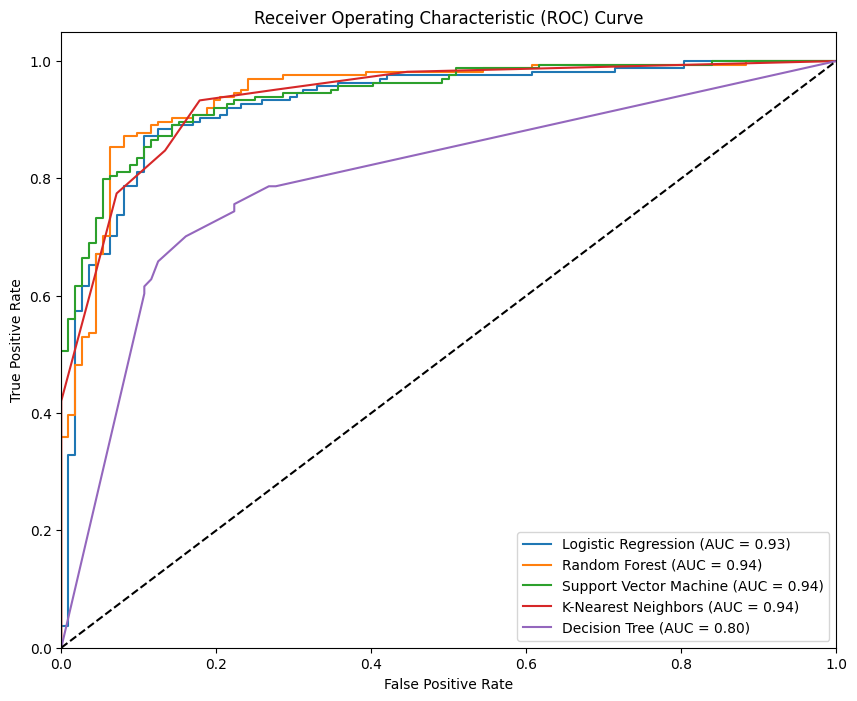

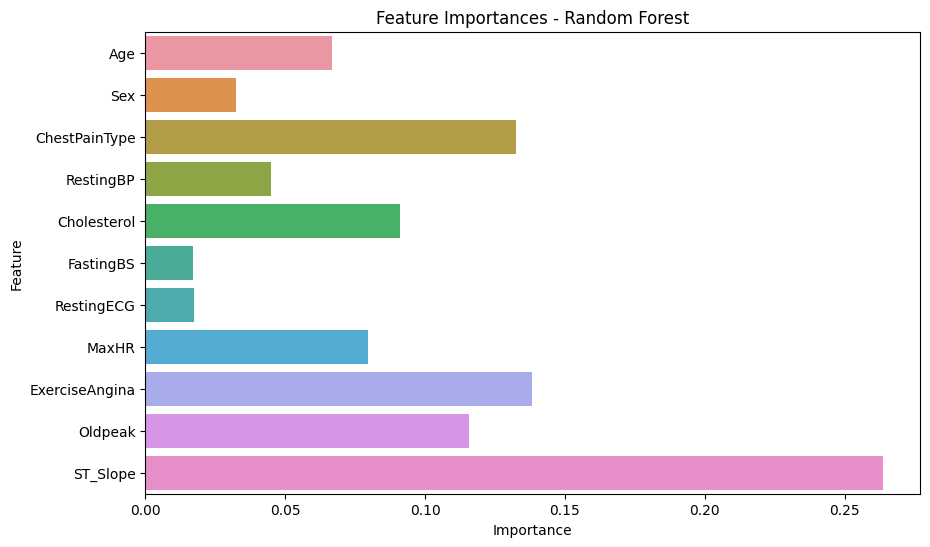

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  

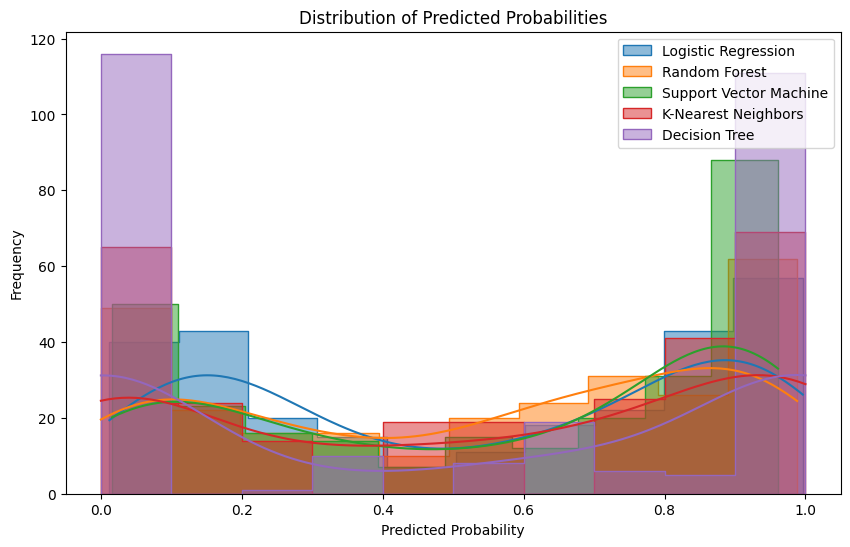

In [11]:
# Plot ROC Curves
plt.figure(figsize=(10, 8))
for model_name, result in results.items():
    fpr, tpr = result['ROC Curve']
    plt.plot(fpr, tpr, label=f'{model_name} (AUC = {result["ROC AUC Score"]:.2f})')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

# Additional Visualizations
# Feature importance for Random Forest
if 'Random Forest' in results:
    rf_model = results['Random Forest']['Model']
    
    # Extract the Random Forest model from the pipeline
    if hasattr(rf_model.named_steps['randomforestclassifier'], 'feature_importances_'):
        feature_importances = rf_model.named_steps['randomforestclassifier'].feature_importances_
        feature_names = X.columns
        
        # Plot feature importances
        plt.figure(figsize=(10, 6))
        sns.barplot(x=feature_importances, y=feature_names)
        plt.title('Feature Importances - Random Forest')
        plt.xlabel('Importance')
        plt.ylabel('Feature')
        plt.show()

# Distribution of Predicted Probabilities
plt.figure(figsize=(10, 6))
for model_name, result in results.items():
    best_model = result['Model']
    
    # Predict probabilities
    y_prob = best_model.predict_proba(X_test)[:, 1]
    
    # Plot distribution of predicted probabilities
    sns.histplot(y_prob, kde=True, label=model_name, element='step')
    
plt.title('Distribution of Predicted Probabilities')
plt.xlabel('Predicted Probability')
plt.ylabel('Frequency')
plt.legend()
plt.show()